<a href="https://colab.research.google.com/github/waltermaffy/ESP-ATTENDANCE/blob/master/PROGAN/PROGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROGRESSING GROWING GAN
code from https://github.com/akanimax/pro_gan_pytorch/

In [0]:
import os
import time, timeit, datetime
import copy, zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torchvision as tv
from torchvision.transforms import ToTensor, Normalize, Compose, Resize, CenterCrop
from torchvision import datasets
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
from torch.nn import DataParallel, ModuleList, AvgPool2d
from torch.nn import Conv2d, ConvTranspose2d, LeakyReLU, Embedding
from torch.nn.modules.utils import _pair
from torch.nn.functional import conv2d, conv_transpose2d, linear, interpolate
from torch.utils.data import DataLoader
from numpy import sqrt, prod

from google.colab import drive
import imageio
from pathlib import Path

# PARAMETERS

In [0]:
dataset_name = 'CIFAR10'
loss = 'wgan-gp' #["wgan-gp", "wgan", "lsgan", "lsgan-with-sigmoid", "hinge", "standard-gan" or "relativistic-hinge"]
depth = 4           # [4x4, 8x8, 16x16, 32x32, 64x64, ...]
dimensions = ['4x4', '8x8', '16X16', '32x32', '64x64', '128x128']
batch_size = 64
lr = 0.001
latent_size = 128
epochs = 8
img_size = [32,32,3]
# hyper-parameters per depth (resolution)
num_epochs = [epochs for _ in range(depth)]
fade_ins = [50 for _ in range(depth)]
batch_sizes = [batch_size for _ in range(depth)]
weights_backup = True

#TO DO: SAVE LOG FILE WITH PARAMETERS OF RUN, MAYBE A MEAN OF THE LOSS??

In [0]:
device = th.device("cuda" if th.cuda.is_available() else "cpu") # select the device to be used for training

if weights_backup: 
  drive.mount('/content/drive')
  path = '/content/drive/My Drive/PROGAN/'
  img_path = path + 'images/' + dataset_name + '/' + loss + '_bs' + str(batch_size) + '_epochs' + str(epochs)
  checkpoint_path = path + 'weights/' + dataset_name + '/' + loss + '_bs' + str(batch_size) + '/'
  os.makedirs(img_path, exist_ok=True)
  os.makedirs(checkpoint_path, exist_ok=True)
  #checkpoint_file = os.path.join(checkpoint_path,  'ckpt_depth' + str(current_depth) + "_epoch" + str(epoch) + ".pt")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA LOADER

In [0]:
def get_transform(new_size=None):
    """
    obtain the image transforms required for the input data
    :param new_size: size of the resized images
    :return: image_transform => transform object from TorchVision
    """
    if new_size is not None:
        image_transform = Compose([
            Resize(new_size),
            ToTensor(),
            Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
    else:
        image_transform = Compose([
            ToTensor(),
            Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
    return image_transform

def download_celeba():
    !mkdir celeba && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
    with zipfile.ZipFile("celeba.zip","r") as zip_ref:
        zip_ref.extractall("celeba/")
    print('Celeba Dataset downloaded')

def get_dataset(dataset_name):
    transform=Compose([Resize(img_size[0]),
                       CenterCrop(img_size[0]),
                       ToTensor(),
                       Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    if dataset_name == 'CIFAR10':
        dataset = datasets.CIFAR10(root='./cifar10', download=True, transform=transform)
    elif dataset_name == 'LSUN':
        dataset = datasets.LSUN(root='./lsun',classes=['bedroom_train'], transform=transforms)
    elif dataset_name== 'CELEBA':
        download_celeba()
        dataset = datasets.ImageFolder('./celeba', transform=transform)
    elif  dataset_name== 'MNIST':
        dataset = datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
    elif  dataset_name== 'FASHION':
        dataset = datasets.FashionMNIST(root='./fashion', download=True, transform=transform)
    return dataset

def get_data_loader(dataset, batch_size, num_workers):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers )


In [0]:

dataset = get_dataset(dataset_name)
    

Files already downloaded and verified


# CUSTOM LAYERS

In [0]:
# extending Conv2D and Deconv2D layers for equalized learning rate logic
class _equalized_conv2d(th.nn.Module):
    """ conv2d with the concept of equalized learning rate
        Args:
            :param c_in: input channels
            :param c_out:  output channels
            :param k_size: kernel size (h, w) should be a tuple or a single integer
            :param stride: stride for conv
            :param pad: padding
            :param bias: whether to use bias or not
    """

    def __init__(self, c_in, c_out, k_size, stride=1, pad=0, bias=True):
        """ constructor for the class """
        
        super(_equalized_conv2d, self).__init__()

        # define the weight and bias if to be used
        self.weight = th.nn.Parameter(th.nn.init.normal_(th.empty(c_out, c_in, *_pair(k_size))))
        self.use_bias = bias
        self.stride = stride
        self.pad = pad

        if self.use_bias:
            self.bias = th.nn.Parameter(th.FloatTensor(c_out).fill_(0))

        fan_in = prod(_pair(k_size)) * c_in  # value of fan_in
        self.scale = sqrt(2) / sqrt(fan_in)

    def forward(self, x):
        """
        forward pass of the network
        :param x: input
        :return: y => output
        """
        return conv2d(input=x,
                      weight=self.weight * self.scale,  # scale the weight on runtime
                      bias=self.bias if self.use_bias else None,
                      stride=self.stride,
                      padding=self.pad)

    def extra_repr(self):
        return ", ".join(map(str, self.weight.shape))

class _equalized_deconv2d(th.nn.Module):
    """ Transpose convolution using the equalized learning rate
        Args:
            :param c_in: input channels
            :param c_out: output channels
            :param k_size: kernel size
            :param stride: stride for convolution transpose
            :param pad: padding
            :param bias: whether to use bias or not
    """

    def __init__(self, c_in, c_out, k_size, stride=1, pad=0, bias=True):
        """ constructor for the class """

        super(_equalized_deconv2d, self).__init__()

        # define the weight and bias if to be used
        self.weight = th.nn.Parameter(th.nn.init.normal_(th.empty(c_in, c_out, *_pair(k_size))))
        self.use_bias = bias
        self.stride = stride
        self.pad = pad

        if self.use_bias:
            self.bias = th.nn.Parameter(th.FloatTensor(c_out).fill_(0))

        fan_in = c_in  # value of fan_in for deconv
        self.scale = sqrt(2) / sqrt(fan_in)

    def forward(self, x):
        """
        forward pass of the layer
        :param x: input
        :return: y => output
        """

        return conv_transpose2d(input=x,
                                weight=self.weight * self.scale,  # scale the weight on runtime
                                bias=self.bias if self.use_bias else None,
                                stride=self.stride,
                                padding=self.pad)

    def extra_repr(self):
        return ", ".join(map(str, self.weight.shape))

class _equalized_linear(th.nn.Module):
    """ Linear layer using equalized learning rate
        Args:
            :param c_in: number of input channels
            :param c_out: number of output channels
            :param bias: whether to use bias with the linear layer
    """

    def __init__(self, c_in, c_out, bias=True):
        """
        Linear layer modified for equalized learning rate
        """
        super(_equalized_linear, self).__init__()

        self.weight = th.nn.Parameter(th.nn.init.normal_(th.empty(c_out, c_in)))
        self.use_bias = bias

        if self.use_bias:
            self.bias = th.nn.Parameter(th.FloatTensor(c_out).fill_(0))

        fan_in = c_in
        self.scale = sqrt(2) / sqrt(fan_in)

    def forward(self, x):
        """
        forward pass of the layer
        :param x: input
        :return: y => output
        """
        return linear(x, self.weight * self.scale, self.bias if self.use_bias else None)

# ----------------------------------------------------------------------------
# Pixelwise feature vector normalization.
# reference: https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py#L120
# ----------------------------------------------------------------------------
class PixelwiseNorm(th.nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the module
        :param x: input activations volume
        :param alpha: small number for numerical stability
        :return: y => pixel normalized activations
        """
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y


# ==========================================================
# Layers required for Building The generator and discriminator
# ==========================================================
class GenInitialBlock(th.nn.Module):
    """ Module implementing the initial block of the input """

    def __init__(self, in_channels, use_eql):
        """
        constructor for the inner class
        :param in_channels: number of input channels to the block
        :param use_eql: whether to use equalized learning rate
        """
        
        super(GenInitialBlock, self).__init__()

        if use_eql:
            self.conv_1 = _equalized_deconv2d(in_channels, in_channels, (4, 4), bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, in_channels, (3, 3), pad=1, bias=True)

        else:
            self.conv_1 = ConvTranspose2d(in_channels, in_channels, (4, 4), bias=True)
            self.conv_2 = Conv2d(in_channels, in_channels, (3, 3), padding=1, bias=True)

        # Pixelwise feature vector normalization operation
        self.pixNorm = PixelwiseNorm()

        # leaky_relu:
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        """
        forward pass of the block
        :param x: input to the module
        :return: y => output
        """
        # convert the tensor shape:
        y = th.unsqueeze(th.unsqueeze(x, -1), -1)

        # perform the forward computations:
        y = self.lrelu(self.conv_1(y))
        y = self.lrelu(self.conv_2(y))

        # apply pixel norm
        y = self.pixNorm(y)

        return y


class GenGeneralConvBlock(th.nn.Module):
    """ Module implementing a general convolutional block """

    def __init__(self, in_channels, out_channels, use_eql):
        """
        constructor for the class
        :param in_channels: number of input channels to the block
        :param out_channels: number of output channels required
        :param use_eql: whether to use equalized learning rate
        """
        
        super(GenGeneralConvBlock, self).__init__()

        self.upsample = lambda x: interpolate(x, scale_factor=2)

        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels, out_channels, (3, 3), pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(out_channels, out_channels, (3, 3), pad=1, bias=True)
        else:
            self.conv_1 = Conv2d(in_channels, out_channels, (3, 3), padding=1, bias=True)
            self.conv_2 = Conv2d(out_channels, out_channels, (3, 3), padding=1, bias=True)

        # Pixelwise feature vector normalization operation
        self.pixNorm = PixelwiseNorm()

        # leaky_relu:
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        """
        forward pass of the block
        :param x: input
        :return: y => output
        """
        y = self.upsample(x)
        y = self.pixNorm(self.lrelu(self.conv_1(y)))
        y = self.pixNorm(self.lrelu(self.conv_2(y)))

        return y


# function to calculate the Exponential moving averages for the Generator weights
# This function updates the exponential average weights based on the current training
def update_average(model_tgt, model_src, beta):
    """
    update the model_target using exponential moving averages
    :param model_tgt: target model
    :param model_src: source model
    :param beta: value of decay beta
    :return: None (updates the target model)
    """

    # utility function for toggling the gradient requirements of the models
    def toggle_grad(model, requires_grad):
        for p in model.parameters():
            p.requires_grad_(requires_grad)

    # turn off gradient calculation
    toggle_grad(model_tgt, False)
    toggle_grad(model_src, False)

    param_dict_src = dict(model_src.named_parameters())

    for p_name, p_tgt in model_tgt.named_parameters():
        p_src = param_dict_src[p_name]
        assert (p_src is not p_tgt)
        p_tgt.copy_(beta * p_tgt + (1. - beta) * p_src)

    # turn back on the gradient calculation
    toggle_grad(model_tgt, True)
    toggle_grad(model_src, True)


class MinibatchStdDev(th.nn.Module):
    """
    Minibatch standard deviation layer for the discriminator
    """

    def __init__(self):
        """
        derived class constructor
        """
        super(MinibatchStdDev, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the layer
        :param x: input activation volume
        :param alpha: small number for numerical stability
        :return: y => x appended with standard deviation constant map
        """
        batch_size, _, height, width = x.shape

        # [B x C x H x W] Subtract mean over batch.
        y = x - x.mean(dim=0, keepdim=True)

        # [1 x C x H x W]  Calc standard deviation over batch
        y = th.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)

        # [1]  Take average over feature_maps and pixels.
        y = y.mean().view(1, 1, 1, 1)

        # [B x 1 x H x W]  Replicate over group and pixels.
        y = y.repeat(batch_size, 1, height, width)

        # [B x C x H x W]  Append as new feature_map.
        y = th.cat([x, y], 1)

        # return the computed values:
        return y


class DisFinalBlock(th.nn.Module):
    """ Final block for the Discriminator """

    def __init__(self, in_channels, use_eql):
        """
        constructor of the class
        :param in_channels: number of input channels
        :param use_eql: whether to use equalized learning rate
        """
       
        super(DisFinalBlock, self).__init__()

        # declare the required modules for forward pass
        self.batch_discriminator = MinibatchStdDev()
        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels + 1, in_channels, (3, 3), pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, in_channels, (4, 4), bias=True)
            # final conv layer emulates a fully connected layer
            self.conv_3 = _equalized_conv2d(in_channels, 1, (1, 1), bias=True)
        else:
            self.conv_1 = Conv2d(in_channels + 1, in_channels, (3, 3), padding=1, bias=True)
            self.conv_2 = Conv2d(in_channels, in_channels, (4, 4), bias=True)
            # final conv layer emulates a fully connected layer
            self.conv_3 = Conv2d(in_channels, 1, (1, 1), bias=True)

        # leaky_relu:
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        """
        forward pass of the FinalBlock
        :param x: input
        :return: y => output
        """
        # minibatch_std_dev layer
        y = self.batch_discriminator(x)

        # define the computations
        y = self.lrelu(self.conv_1(y))
        y = self.lrelu(self.conv_2(y))

        # fully connected layer
        y = self.conv_3(y)  # This layer has linear activation

        # flatten the output raw discriminator scores
        return y.view(-1)


class ConDisFinalBlock(th.nn.Module):
    """ Final block for the Conditional Discriminator
        Uses the Projection mechanism from the paper -> https://arxiv.org/pdf/1802.05637.pdf
    """

    def __init__(self, in_channels, num_classes, use_eql):
        """
        constructor of the class
        :param in_channels: number of input channels
        :param num_classes: number of classes for conditional discrimination
        :param use_eql: whether to use equalized learning rate
        """
       
        super(ConDisFinalBlock, self).__init__()

        # declare the required modules for forward pass
        self.batch_discriminator = MinibatchStdDev()
        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels + 1, in_channels, (3, 3), pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, in_channels, (4, 4), bias=True)

            # final conv layer emulates a fully connected layer
            self.conv_3 = _equalized_conv2d(in_channels, 1, (1, 1), bias=True)
        else:
            self.conv_1 = Conv2d(in_channels + 1, in_channels, (3, 3), padding=1, bias=True)
            self.conv_2 = Conv2d(in_channels, in_channels, (4, 4), bias=True)

            # final conv layer emulates a fully connected layer
            self.conv_3 = Conv2d(in_channels, 1, (1, 1), bias=True)

        # we also need an embedding matrix for the label vectors
        self.label_embedder = Embedding(num_classes, in_channels, max_norm=1)

        # leaky_relu:
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x, labels):
        """
        forward pass of the FinalBlock
        :param x: input
        :param labels: samples' labels for conditional discrimination
                       Note that these are pure integer labels [Batch_size x 1]
        :return: y => output
        """
        # minibatch_std_dev layer
        y = self.batch_discriminator(x)  # [B x C x 4 x 4]

        # perform the forward pass
        y = self.lrelu(self.conv_1(y))  # [B x C x 4 x 4]

        # obtain the computed features
        y = self.lrelu(self.conv_2(y))  # [B x C x 1 x 1]

        # embed the labels
        labels = self.label_embedder(labels)  # [B x C]

        # compute the inner product with the label embeddings
        y_ = th.squeeze(th.squeeze(y, dim=-1), dim=-1)  # [B x C]
        projection_scores = (y_ * labels).sum(dim=-1)  # [B]

        # normal discrimination score
        y = self.lrelu(self.conv_3(y))  # This layer has linear activation

        # calculate the total score
        final_score = y.view(-1) + projection_scores

        # return the output raw discriminator scores
        return final_score


class DisGeneralConvBlock(th.nn.Module):
    """ General block in the discriminator  """

    def __init__(self, in_channels, out_channels, use_eql):
        """
        constructor of the class
        :param in_channels: number of input channels
        :param out_channels: number of output channels
        :param use_eql: whether to use equalized learning rate
        """
    
        super(DisGeneralConvBlock, self).__init__()

        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels, in_channels, (3, 3), pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, out_channels, (3, 3), pad=1, bias=True)
        else:
            self.conv_1 = Conv2d(in_channels, in_channels, (3, 3), padding=1, bias=True)
            self.conv_2 = Conv2d(in_channels, out_channels, (3, 3), padding=1, bias=True)

        self.downSampler = AvgPool2d(2)

        # leaky_relu:
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        """
        forward pass of the module
        :param x: input
        :return: y => output
        """
        # define the computations
        y = self.lrelu(self.conv_1(x))
        y = self.lrelu(self.conv_2(y))
        y = self.downSampler(y)

        return y

# LOSSES

In [0]:
# =============================================================
# Interface for the losses
# =============================================================

class GANLoss:
    """ Base class for all losses
        @args:
            dis: Discriminator used for calculating the loss
                 Note this must be a part of the GAN framework
    """

    def __init__(self, dis):
        self.dis = dis

    def dis_loss(self, real_samps, fake_samps, height, alpha):
        """
        calculate the discriminator loss using the following data
        :param real_samps: batch of real samples
        :param fake_samps: batch of generated (fake) samples
        :param height: current height at which training is going on
        :param alpha: current value of the fader alpha
        :return: loss => calculated loss Tensor
        """
        raise NotImplementedError("dis_loss method has not been implemented")

    def gen_loss(self, real_samps, fake_samps, height, alpha):
        """
        calculate the generator loss
        :param real_samps: batch of real samples
        :param fake_samps: batch of generated (fake) samples
        :param height: current height at which training is going on
        :param alpha: current value of the fader alpha
        :return: loss => calculated loss Tensor
        """
        raise NotImplementedError("gen_loss method has not been implemented")

# =============================================================
# Normal versions of the Losses:
# =============================================================

class StandardGAN(GANLoss):

    def __init__(self, dis):
        from torch.nn import BCEWithLogitsLoss

        super().__init__(dis)

        # define the criterion and activation used for object
        self.criterion = BCEWithLogitsLoss()

    def dis_loss(self, real_samps, fake_samps, height, alpha):
        # small assertion:
        assert real_samps.device == fake_samps.device, \
            "Real and Fake samples are not on the same device"

        # device for computations:
        device = fake_samps.device

        # predictions for real images and fake images separately :
        r_preds = self.dis(real_samps, height, alpha)
        f_preds = self.dis(fake_samps, height, alpha)

        # calculate the real loss:
        real_loss = self.criterion(
            th.squeeze(r_preds),
            th.ones(real_samps.shape[0]).to(device))

        # calculate the fake loss:
        fake_loss = self.criterion(
            th.squeeze(f_preds),
            th.zeros(fake_samps.shape[0]).to(device))

        # return final losses
        return (real_loss + fake_loss) / 2

    def gen_loss(self, _, fake_samps, height, alpha):
        preds, _, _ = self.dis(fake_samps, height, alpha)
        return self.criterion(th.squeeze(preds),
                              th.ones(fake_samps.shape[0]).to(fake_samps.device))


class WGAN_GP(GANLoss):

    def __init__(self, dis, drift=0.001, use_gp=False):
        super().__init__(dis)
        self.drift = drift
        self.use_gp = use_gp

    def __gradient_penalty(self, real_samps, fake_samps,
                           height, alpha, reg_lambda=10):
        """
        private helper for calculating the gradient penalty
        :param real_samps: real samples
        :param fake_samps: fake samples
        :param height: current depth in the optimization
        :param alpha: current alpha for fade-in
        :param reg_lambda: regularisation lambda
        :return: tensor (gradient penalty)
        """
        batch_size = real_samps.shape[0]

        # generate random epsilon
        epsilon = th.rand((batch_size, 1, 1, 1)).to(fake_samps.device)

        # create the merge of both real and fake samples
        merged = epsilon * real_samps + ((1 - epsilon) * fake_samps)
        merged.requires_grad_(True)

        # forward pass
        op = self.dis(merged, height, alpha)

        # perform backward pass from op to merged for obtaining the gradients
        gradient = th.autograd.grad(outputs=op, inputs=merged,
                                    grad_outputs=th.ones_like(op), create_graph=True,
                                    retain_graph=True, only_inputs=True)[0]

        # calculate the penalty using these gradients
        gradient = gradient.view(gradient.shape[0], -1)
        penalty = reg_lambda * ((gradient.norm(p=2, dim=1) - 1) ** 2).mean()

        # return the calculated penalty:
        return penalty

    def dis_loss(self, real_samps, fake_samps, height, alpha):
        # define the (Wasserstein) loss
        fake_out = self.dis(fake_samps, height, alpha)
        real_out = self.dis(real_samps, height, alpha)

        loss = (th.mean(fake_out) - th.mean(real_out)
                + (self.drift * th.mean(real_out ** 2)))

        if self.use_gp:
            # calculate the WGAN-GP (gradient penalty)
            gp = self.__gradient_penalty(real_samps, fake_samps, height, alpha)
            loss += gp

        return loss

    def gen_loss(self, _, fake_samps, height, alpha):
        # calculate the WGAN loss for generator
        loss = -th.mean(self.dis(fake_samps, height, alpha))

        return loss


class LSGAN(GANLoss):

    def __init__(self, dis):
        super().__init__(dis)

    def dis_loss(self, real_samps, fake_samps, height, alpha):
        return 0.5 * (th.mean((self.dis(real_samps, height, alpha) - 1) ** 2)
                      + (th.mean(self.dis(fake_samps, height, alpha) ** 2)))

    def gen_loss(self, _, fake_samps, height, alpha):
        return 0.5 * (th.mean((self.dis(fake_samps, height, alpha) - 1) ** 2))


class LSGAN_SIGMOID(GANLoss):

    def __init__(self, dis):
        super().__init__(dis)

    def dis_loss(self, real_samps, fake_samps, height, alpha):
        from torch.nn.functional import sigmoid
        real_scores = sigmoid(self.dis(real_samps, height, alpha))
        fake_scores = sigmoid(self.dis(fake_samps, height, alpha))
        return 0.5 * ((th.mean((real_scores - 1) ** 2)) + th.mean(fake_scores ** 2))

    def gen_loss(self, _, fake_samps, height, alpha):
        from torch.nn.functional import sigmoid
        scores = sigmoid(self.dis(fake_samps, height, alpha))
        return 0.5 * (th.mean((scores - 1) ** 2))


class HingeGAN(GANLoss):

    def __init__(self, dis):
        super().__init__(dis)

    def dis_loss(self, real_samps, fake_samps, height, alpha):
        r_preds = self.dis(real_samps, height, alpha)
        f_preds = self.dis(fake_samps, height, alpha)

        loss = (th.mean(th.nn.ReLU()(1 - r_preds)) +
                th.mean(th.nn.ReLU()(1 + f_preds)))

        return loss

    def gen_loss(self, _, fake_samps, height, alpha):
        return -th.mean(self.dis(fake_samps, height, alpha))


class RelativisticAverageHingeGAN(GANLoss):

    def __init__(self, dis):
        super().__init__(dis)

    def dis_loss(self, real_samps, fake_samps, height, alpha):
        # Obtain predictions
        r_preds = self.dis(real_samps, height, alpha)
        f_preds = self.dis(fake_samps, height, alpha)

        # difference between real and fake:
        r_f_diff = r_preds - th.mean(f_preds)

        # difference between fake and real samples
        f_r_diff = f_preds - th.mean(r_preds)

        # return the loss
        loss = (th.mean(th.nn.ReLU()(1 - r_f_diff))
                + th.mean(th.nn.ReLU()(1 + f_r_diff)))

        return loss

    def gen_loss(self, real_samps, fake_samps, height, alpha):
        # Obtain predictions
        r_preds = self.dis(real_samps, height, alpha)
        f_preds = self.dis(fake_samps, height, alpha)

        # difference between real and fake:
        r_f_diff = r_preds - th.mean(f_preds)

        # difference between fake and real samples
        f_r_diff = f_preds - th.mean(r_preds)

        # return the loss
        return (th.mean(th.nn.ReLU()(1 + r_f_diff))
                + th.mean(th.nn.ReLU()(1 - f_r_diff)))

# MODELS

In [0]:
# ========================================================================================
# Generator Module
# ========================================================================================

class Generator(th.nn.Module):
    """ Generator of the GAN network """

    def __init__(self, depth=7, latent_size=512, use_eql=True):
        """
        constructor for the Generator class
        :param depth: required depth of the Network
        :param latent_size: size of the latent manifold
        :param use_eql: whether to use equalized learning rate
        """

        super(Generator, self).__init__()

        assert latent_size != 0 and ((latent_size & (latent_size - 1)) == 0), "latent size not a power of 2"
        if depth >= 4:
            assert latent_size >= np.power(2, depth - 4), "latent size will diminish to zero"

        # state of the generator:
        self.use_eql = use_eql
        self.depth = depth
        self.latent_size = latent_size

        # register the modules required for the GAN
        self.initial_block = GenInitialBlock(self.latent_size, use_eql=self.use_eql)

        # create a module list of the other required general convolution blocks
        self.layers = ModuleList([])  # initialize to empty list

        # create the ToRGB layers for various outputs:
        if self.use_eql:
            self.toRGB = lambda in_channels: _equalized_conv2d(in_channels, 3, (1, 1), bias=True)
        else:
            self.toRGB = lambda in_channels: Conv2d(in_channels, 3, (1, 1), bias=True)

        self.rgb_converters = ModuleList([self.toRGB(self.latent_size)])

        # create the remaining layers
        for i in range(self.depth - 1):
            if i <= 2:
                layer = GenGeneralConvBlock(self.latent_size, self.latent_size, use_eql=self.use_eql)
                rgb = self.toRGB(self.latent_size)
            else:
                layer = GenGeneralConvBlock(
                    int(self.latent_size // np.power(2, i - 3)),
                    int(self.latent_size // np.power(2, i - 2)),
                    use_eql=self.use_eql)
                
                rgb = self.toRGB(int(self.latent_size // np.power(2, i - 2)))
            self.layers.append(layer)
            self.rgb_converters.append(rgb)

        # register the temporary upsampler
        self.temporaryUpsampler = lambda x: interpolate(x, scale_factor=2)


    def sample_latent(self, num_samples):
        return th.randn(num_samples, self.latent_size, 1, 1, device=device)

    def forward(self, x, depth, alpha):
        """
        forward pass of the Generator
        :param x: input noise
        :param depth: current depth from where output is required
        :param alpha: value of alpha for fade-in effect
        :return: y => output
        """

        assert depth < self.depth, "Requested output depth cannot be produced"

        y = self.initial_block(x)

        if depth > 0:
            for block in self.layers[:depth - 1]:
                y = block(y)

            residual = self.rgb_converters[depth - 1](self.temporaryUpsampler(y))
            straight = self.rgb_converters[depth](self.layers[depth - 1](y))

            out = (alpha * straight) + ((1 - alpha) * residual)

        else:
            out = self.rgb_converters[0](y)

        return out


# ========================================================================================
# Discriminator Module
# ========================================================================================

class Discriminator(th.nn.Module):
    """ Discriminator of the GAN """

    def __init__(self, height=7, feature_size=512, use_eql=True):
        """
        constructor for the class
        :param height: total height of the discriminator (Must be equal to the Generator depth)
        :param feature_size: size of the deepest features extracted
                             (Must be equal to Generator latent_size)
        :param use_eql: whether to use equalized learning rate
        """ 
        super(Discriminator, self).__init__()

        assert feature_size != 0 and ((feature_size & (feature_size - 1)) == 0), \
            "latent size not a power of 2"
        if height >= 4:
            assert feature_size >= np.power(2, height - 4), "feature size cannot be produced"

        # create state of the object
        self.use_eql = use_eql
        self.height = height
        self.feature_size = feature_size

        self.final_block = DisFinalBlock(self.feature_size, use_eql=self.use_eql)

        # create a module list of the other required general convolution blocks
        self.layers = ModuleList([])  # initialize to empty list

        # create the fromRGB layers for various inputs:
        if self.use_eql:
            self.fromRGB = lambda out_channels: _equalized_conv2d(3, out_channels, (1, 1), bias=True)
        else:
            self.fromRGB = lambda out_channels: Conv2d(3, out_channels, (1, 1), bias=True)

        self.rgb_to_features = ModuleList([self.fromRGB(self.feature_size)])

        # create the remaining layers
        for i in range(self.height - 1):
            if i > 2:
                layer = DisGeneralConvBlock(
                    int(self.feature_size // np.power(2, i - 2)),
                    int(self.feature_size // np.power(2, i - 3)),
                    use_eql=self.use_eql)
                
                rgb = self.fromRGB(int(self.feature_size // np.power(2, i - 2)))
            else:
                layer = DisGeneralConvBlock(self.feature_size, self.feature_size, use_eql=self.use_eql)
                rgb = self.fromRGB(self.feature_size)

            self.layers.append(layer)
            self.rgb_to_features.append(rgb)

        # register the temporary downSampler
        self.temporaryDownsampler = AvgPool2d(2)

    def forward(self, x, height, alpha):
        """
        forward pass of the discriminator
        :param x: input to the network
        :param height: current height of operation (Progressive GAN)
        :param alpha: current value of alpha for fade-in
        :return: out => raw prediction values (WGAN-GP)
        """

        assert height < self.height, "Requested output depth cannot be produced"

        if height > 0:
            residual = self.rgb_to_features[height - 1](self.temporaryDownsampler(x))
            straight = self.layers[height - 1](self.rgb_to_features[height](x))
            y = (alpha * straight) + ((1 - alpha) * residual)
            for block in reversed(self.layers[:height - 1]):
                y = block(y)
        else:
            y = self.rgb_to_features[0](x)
        out = self.final_block(y)
        return out

# ========================================================================================
# ProGAN Module 
# ========================================================================================

class ProGAN:
    """ Wrapper around the Generator and the Discriminator """

    def __init__(self, depth=7, latent_size=512, lr=lr, beta_1=0,
                 beta_2=0.99, eps=1e-8, drift=0.001, n_critic=1, use_eql=True,
                 loss="wgan-gp", use_ema=True, ema_decay=0.999,
                 device=th.device("cpu")):
        """
        constructor for the class
        :param depth: depth of the GAN (will be used for each generator and discriminator)
        :param latent_size: latent size of the manifold used by the GAN
        :param learning_rate: learning rate for Adam
        :param beta_1: beta_1 for Adam
        :param beta_2: beta_2 for Adam
        :param eps: epsilon for Adam
        :param n_critic: number of times to update discriminator per generator update
        :param drift: drift penalty for the
                      (Used only if loss is wgan or wgan-gp)
        :param use_eql: whether to use equalized learning rate
        :param loss: the loss function to be used
                     Can either be a string =>
                          ["wgan-gp", "wgan", "lsgan", "lsgan-with-sigmoid", "hinge", "standard-gan" or "relativistic-hinge"]
                     Or an instance of GANLoss
        :param use_ema: boolean for whether to use exponential moving averages
        :param ema_decay: value of mu for ema
        :param device: device to run the GAN on (GPU / CPU)
        """

        # Create the Generator and the Discriminator
        self.gen = Generator(depth, latent_size, use_eql=use_eql).to(device)
        self.dis = Discriminator(depth, latent_size, use_eql=use_eql).to(device)

        # if code is to be run on GPU, we can use DataParallel:
        if device == th.device("cuda"):
            self.gen = DataParallel(self.gen)
            self.dis = DataParallel(self.dis)

        # state of the object
        self.latent_size = latent_size
        self.depth = depth
        self.use_ema = use_ema
        self.ema_decay = ema_decay
        self.n_critic = n_critic
        self.use_eql = use_eql
        self.device = device
        self.drift = drift

        self.fixed_latents = th.randn(64, latent_size).to(device)

        # define the optimizers for the discriminator and generator
        self.gen_optim = Adam(self.gen.parameters(), lr=lr, betas=(beta_1, beta_2), eps=eps)
        self.dis_optim = Adam(self.dis.parameters(), lr=lr, betas=(beta_1, beta_2), eps=eps)

        # define the loss function used for training the GAN
        self.loss = self.__setup_loss(loss)

        if self.use_ema:
          
            # create a shadow copy of the generator
            self.gen_shadow = copy.deepcopy(self.gen)

            # updater function:
            self.ema_updater = update_average

            # initialize the gen_shadow weights equal to the weights of gen
            self.ema_updater(self.gen_shadow, self.gen, beta=0)

    def __setup_loss(self, loss):
        
        if isinstance(loss, str):
            loss = loss.lower()  # lowercase the string
            if loss == "wgan":
                loss = WGAN_GP(self.dis, self.drift, use_gp=False)
                # note if you use just wgan, you will have to use weight clipping
                # in order to prevent gradient exploding
                # check the optimize_discriminator method where this has been taken care of.

            elif loss == "wgan-gp":
                loss = WGAN_GP(self.dis, self.drift, use_gp=True)

            elif loss == "standard-gan":
                loss = StandardGAN(self.dis)

            elif loss == "lsgan":
                loss = LSGAN(self.dis)

            elif loss == "lsgan-with-sigmoid":
                loss = LSGAN_SIGMOID(self.dis)

            elif loss == "hinge":
                loss = HingeGAN(self.dis)

            elif loss == "relativistic-hinge":
                loss = RelativisticAverageHingeGAN(self.dis)

            else:
                raise ValueError("Unknown loss function requested")

        elif not isinstance(loss, GANLoss):
            raise ValueError("loss is neither an instance of GANLoss nor a string")

        return loss

    def __progressive_downsampling(self, real_batch, depth, alpha):
        """
        private helper for downsampling the original images in order to facilitate the
        progressive growing of the layers.
        :param real_batch: batch of real samples
        :param depth: depth at which training is going on
        :param alpha: current value of the fader alpha
        :return: real_samples => modified real batch of samples
        """

        # downsample the real_batch for the given depth
        down_sample_factor = int(np.power(2, self.depth - depth - 1))
        prior_downsample_factor = max(int(np.power(2, self.depth - depth)), 0)

        ds_real_samples = AvgPool2d(down_sample_factor)(real_batch)

        if depth > 0:
            prior_ds_real_samples = interpolate(AvgPool2d(prior_downsample_factor)(real_batch), scale_factor=2)
        else:
            prior_ds_real_samples = ds_real_samples

        # real samples are a combination of ds_real_samples and prior_ds_real_samples
        real_samples = (alpha * ds_real_samples) + ((1 - alpha) * prior_ds_real_samples)

        # return the so computed real_samples
        return real_samples

    def optimize_discriminator(self, noise, real_batch, depth, alpha):
        """
        performs one step of weight update on discriminator using the batch of data
        :param noise: input noise of sample generation
        :param real_batch: real samples batch
        :param depth: current depth of optimization
        :param alpha: current alpha for fade-in
        :return: current loss (Wasserstein loss)
        """

        real_samples = self.__progressive_downsampling(real_batch, depth, alpha)

        loss_val = 0
        for _ in range(self.n_critic):
            # generate a batch of samples
            fake_samples = self.gen(noise, depth, alpha).detach()

            loss = self.loss.dis_loss(real_samples, fake_samples, depth, alpha)

            # optimize discriminator
            self.dis_optim.zero_grad()
            loss.backward()
            self.dis_optim.step()

            loss_val += loss.item()

        return loss_val / self.n_critic

    def optimize_generator(self, noise, real_batch, depth, alpha):
        """
        performs one step of weight update on generator for the given batch_size
        :param noise: input random noise required for generating samples
        :param real_batch: batch of real samples
        :param depth: depth of the network at which optimization is done
        :param alpha: value of alpha for fade-in effect
        :return: current loss (Wasserstein estimate)
        """

        real_samples = self.__progressive_downsampling(real_batch, depth, alpha)

        # generate fake samples:
        fake_samples = self.gen(noise, depth, alpha)

        loss = self.loss.gen_loss(real_samples, fake_samples, depth, alpha)

        # optimize the generator
        self.gen_optim.zero_grad()
        loss.backward()
        self.gen_optim.step()

        # if use_ema is true, apply ema to the generator parameters
        if self.use_ema:
            self.ema_updater(self.gen_shadow, self.gen, self.ema_decay)

        # return the loss value
        return loss.item()

    def store_checkpoint(self, epoch, depth, alpha):
      checkpoint_file = os.path.join(checkpoint_path,  'ckpt_depth' + str(depth) + ".pt")
      th.save({'epoch': epoch,
                  'depth': depth,
                  'alpha': alpha,
                  'generator': self.gen.state_dict(),
                  'discriminator': self.dis.state_dict(),
                  'optimizerG': self.gen_optim.state_dict(),
                  'optimizerD': self.dis_optim.state_dict(),
                  #'loss': self.losses,
                  'fixed_z': self.fixed_latents,
                  #'images_gen': self.training_progress_images
                  }, checkpoint_file)
      print('Saved checkpoint at epoch: ', epoch)
        
    def restore_checkpoint(self,checkpoint_file):
        if Path(checkpoint_file).exists():
          checkpoint = th.load(checkpoint_file)
          self.gen.load_state_dict(checkpoint['generator'])
          self.dis.load_state_dict(checkpoint['discriminator'])
          self.gen_optim.load_state_dict(checkpoint['optimizerG'])
          self.dis_optim.load_state_dict(checkpoint['optimizerD'])
          #self.losses = checkpoint['loss']
          self.fixed_latents = checkpoint['fixed_z']
          #self.training_progress_images = checkpoint['images_gen']
          self.start_epoch = checkpoint['epoch']
          self.depth = checkpoint['depth']
          print('Checkpoint found and restored at epoch {}'.format(self.start_epoch))
        else: 
          print('Checkpoint not used or not exist\n')

    def create_grid(self,scale_factor, epoch, depth, alpha, img_dir, save=False, show=False):
        
        img_file = os.path.join(img_dir,  'epoch' + str(epoch) + ".png")

        with th.no_grad():
            if self.use_ema:
                samples = self.gen_shadow(self.fixed_latents, depth, alpha).detach()
            else:
                samples = self.gen(self.fixed_latents, depth, alpha).detach()
                
        # upsample the image
        if scale_factor > 1:
            samples = interpolate(samples, scale_factor=scale_factor)
                 
        img_grid = make_grid(samples.cpu().data, normalize=True).numpy() 
        img_grid = img_grid.transpose((1, 2, 0))
        plt.figure(figsize=(10,10))
        plt.imshow(img_grid)
        plt.axis('off')
        plt.title('Generated images {} after {} epochs'.format(dimensions[depth],(epoch)))
        if save:
            plt.savefig(img_file)
        if show:
            plt.show()

    def sample_generator(self,n_samples=64):
        latents = self.gen.sample_latent(n_samples)
        generated_data = self.G(latents)
        return generated_data

    def plot_save_generated(self, epoch=epochs, save=False):
        img = make_grid(self.sample_generator().cpu().data,normalize=True).numpy() 
        img = img.transpose((1, 2, 0)) 
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Generated images after {} epochs'.format((epoch+1)))
        if save:
            plt.savefig(image_path + '_generated_%d.png' % (epoch+1))
        plt.show()

    def train(self, dataset, epochs, batch_sizes,
              fade_in_percentage,
              start_depth=0, num_workers=3, image_factor=5, feedback_factor=500,
              sample_dir="./samples/", save_dir="./models/",
              checkpoint_factor=5):
        """
        Utility method for training the ProGAN. Note that you don't have to necessarily use this
        you can use the optimize_generator and optimize_discriminator for your own training routine.
        :param dataset: object of the dataset used for training.
                        Note that this is not the dataloader (we create dataloader in this method
                        since the batch_sizes for resolutions can be different)
        :param epochs: list of number of epochs to train the network for every resolution
        :param batch_sizes: list of batch_sizes for every resolution
        :param fade_in_percentage: list of percentages of epochs per resolution
                                   used for fading in the new layer
                                   not used for first resolution, but dummy value still needed.
        :param num_samples: number of samples generated in sample_sheet. def=36
        :param start_depth: start training from this depth. def=0
        :param num_workers: number of workers for reading the data. def=3
        :param feedback_factor: number of logs per epoch. def=100
        :param log_dir: directory for saving the loss logs. def="./models/"
        :param sample_dir: directory for saving the generated samples. def="./samples/"
        :param checkpoint_factor: save model after these many epochs.
                                  Note that only one model is stored per resolution.
                                  during one resolution, the checkpoint will be updated (Rewritten)
                                  according to this factor.
        :param save_dir: directory for saving the models (.pth files)
        :return: None (Writes multiple files to disk)
        """
       
        assert self.depth == len(batch_sizes), "batch_sizes not compatible with depth"

        # turn the generator and discriminator into train mode
        self.gen.train()
        self.dis.train()
        if self.use_ema:
            self.gen_shadow.train()

        # create a global time counter
        global_time = time.time()

        # create fixed_input for debugging
        
        print("Starting the training process ... ")
        for current_depth in range(start_depth, self.depth):

            print("\n\nCurrently working on Depth: ", current_depth)
            current_res = np.power(2, current_depth + 2)
            print("Current resolution: %d x %d" % (current_res, current_res))

            #Create dir for saving images
            img_dir = img_path + dimensions[current_depth]
            os.makedirs(img_dir, exist_ok=True)

            data = get_data_loader(dataset, batch_sizes[current_depth], num_workers)
            ticker = 1

            for epoch in range(1, epochs[current_depth] + 1):
                start = timeit.default_timer()  # record time at the start of epoch

                print("\nEpoch: %d" % epoch)
                total_batches = len(iter(data))
                
                fader_point = int((fade_in_percentage[current_depth] / 100) * epochs[current_depth] * total_batches)

                step = 0  # counter for number of iterations

                for i, batch in enumerate(data):
                    # calculate the alpha for fading in the layers
                    alpha = ticker / fader_point if ticker <= fader_point else 1

                    # extract current batch of data for training
                    images = batch[0].to(self.device)
                    
                    latents = th.randn(images.shape[0], self.latent_size).to(self.device)

                    # optimize the discriminator:
                    dis_loss = self.optimize_discriminator(latents, images, current_depth, alpha)

                    # optimize the generator:
                    gen_loss = self.optimize_generator(latents, images, current_depth, alpha)

                    # provide a loss feedback
                    if i % int(feedback_factor) == 0:
                        print("[%d/%d]\t [%d/%d]\t Loss_D: %f\tLoss_G: %f" % (epoch, epochs[current_depth], i, len(data), dis_loss, gen_loss))

                    # increment the alpha ticker and the step
                    ticker += 1
                    step += 1
             
                # Save generated images for this epoch
                self.create_grid(scale_factor=int(np.power(2, self.depth - current_depth - 1)),
                                 epoch=epoch, depth=current_depth, alpha=alpha, img_dir=img_dir,
                                 save=True, show=False)
                
                stop = timeit.default_timer()
                print("Time taken for epoch: %.3f secs" % (stop - start))

                #Save checkpoint
                if epoch % checkpoint_factor == 0 or epoch == epochs[current_depth]:
                    self.store_checkpoint(epoch, current_depth, alpha)
                
                #Show generated images
                if epoch % image_factor == 0 or epoch == epochs[current_depth]:
                    self.create_grid(scale_factor=int(np.power(2, self.depth - current_depth - 1)),
                                 epoch=epoch, depth=current_depth, alpha=alpha, img_dir=img_dir,
                                 save=False, show=True)
                    
        # put the gen, shadow_gen and dis in eval mode
        self.gen.eval()
        self.dis.eval()
        if self.use_ema:
            self.gen_shadow.eval()

        print("Training completed ...")

# MAIN

Starting the training process ... 


Currently working on Depth:  0
Current resolution: 4 x 4

Epoch: 1
[1/8]	 [0/782]	 Loss_D: 9.331049	Loss_G: -1.279649
[1/8]	 [500/782]	 Loss_D: 0.140466	Loss_G: -0.522051
Time taken for epoch: 38.397 secs

Epoch: 2
[2/8]	 [0/782]	 Loss_D: -0.037690	Loss_G: 0.090152
[2/8]	 [500/782]	 Loss_D: -0.016652	Loss_G: 0.243470
Time taken for epoch: 38.369 secs

Epoch: 3
[3/8]	 [0/782]	 Loss_D: 0.104221	Loss_G: 0.296619
[3/8]	 [500/782]	 Loss_D: -0.140580	Loss_G: 0.097423
Time taken for epoch: 37.186 secs

Epoch: 4
[4/8]	 [0/782]	 Loss_D: 0.037874	Loss_G: 0.155852
[4/8]	 [500/782]	 Loss_D: -0.076383	Loss_G: 0.310267
Time taken for epoch: 37.424 secs

Epoch: 5
[5/8]	 [0/782]	 Loss_D: 0.032503	Loss_G: 0.036354
[5/8]	 [500/782]	 Loss_D: -0.100983	Loss_G: 0.174253
Time taken for epoch: 36.988 secs
Saved checkpoint at epoch:  5


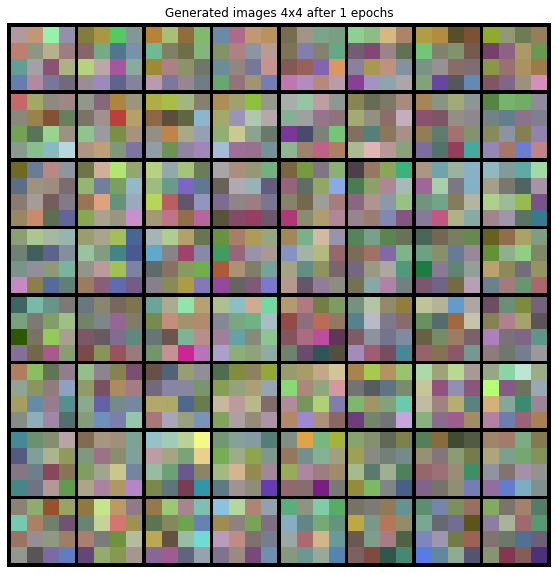

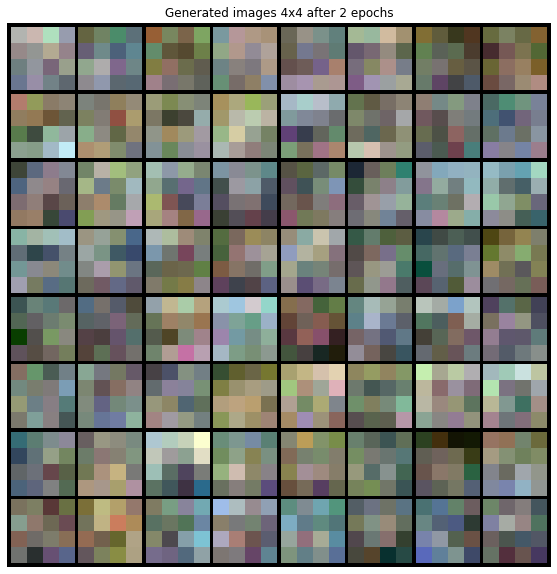

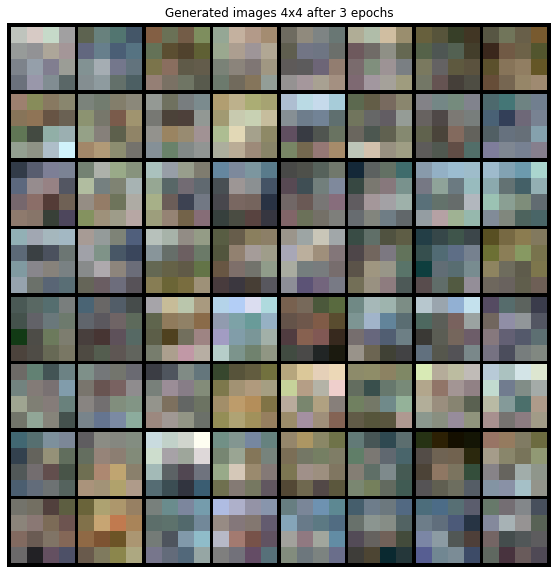

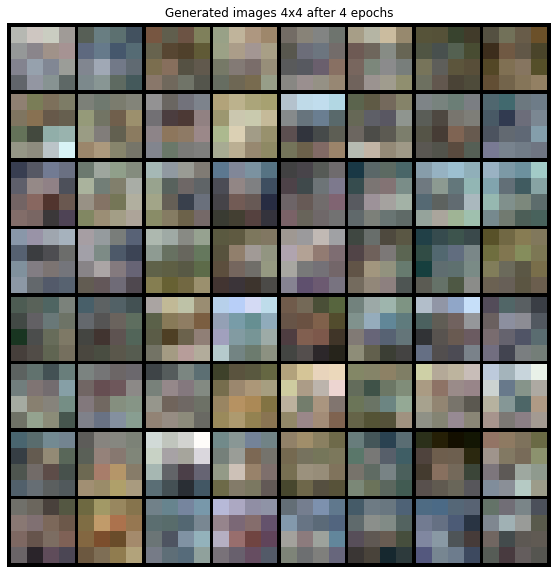

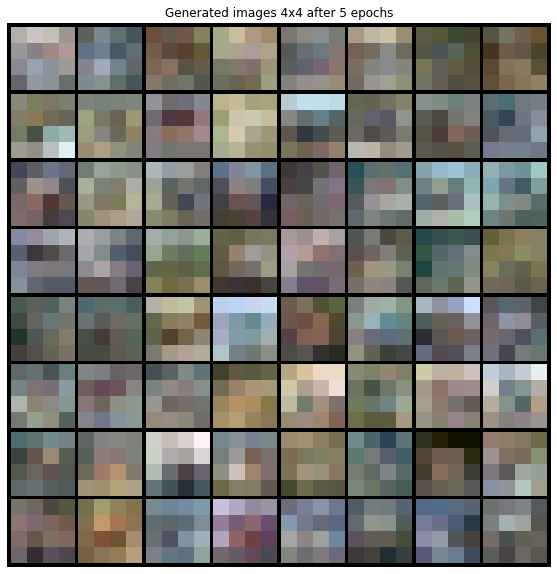

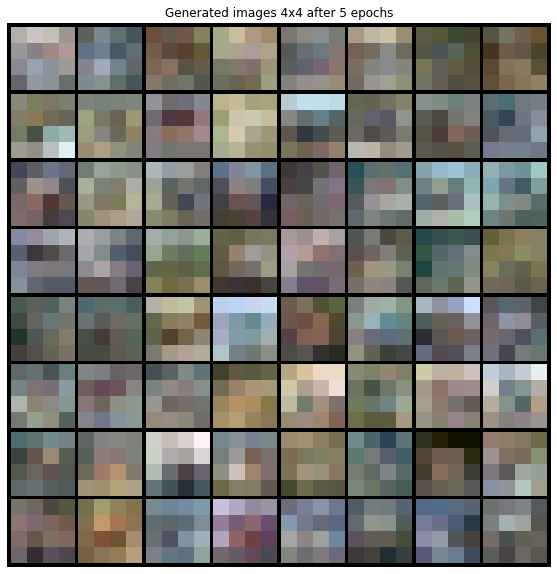


Epoch: 6
[6/8]	 [0/782]	 Loss_D: -0.033398	Loss_G: 0.108168
[6/8]	 [500/782]	 Loss_D: -0.027950	Loss_G: 0.150099
Time taken for epoch: 36.334 secs

Epoch: 7
[7/8]	 [0/782]	 Loss_D: -0.165898	Loss_G: 0.191936
[7/8]	 [500/782]	 Loss_D: -0.167315	Loss_G: 0.310462
Time taken for epoch: 36.533 secs

Epoch: 8
[8/8]	 [0/782]	 Loss_D: -0.213184	Loss_G: 0.322877
[8/8]	 [500/782]	 Loss_D: -0.191734	Loss_G: 0.349918
Time taken for epoch: 37.193 secs
Saved checkpoint at epoch:  8


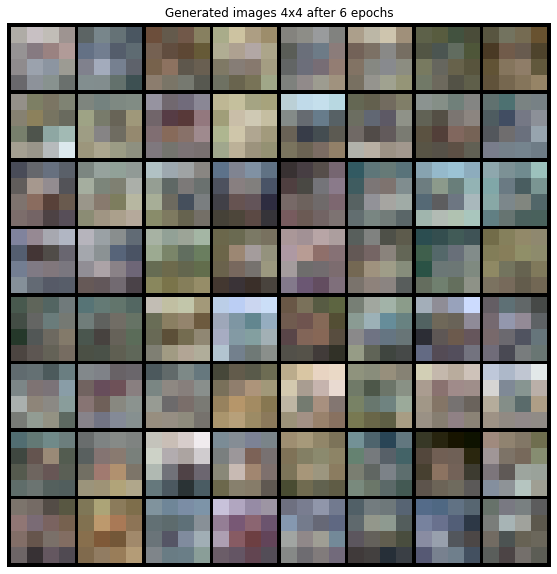

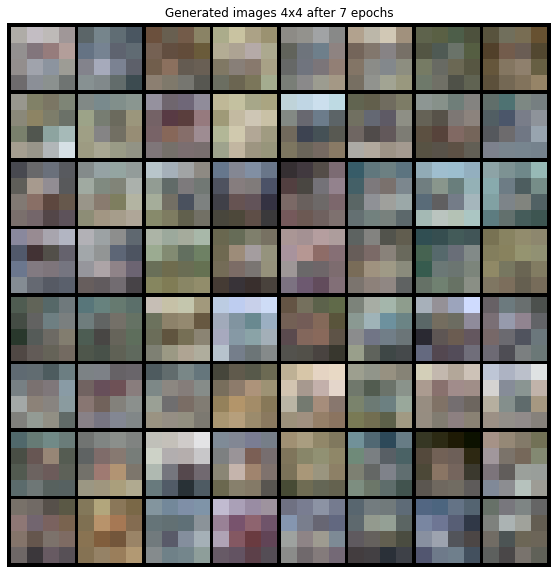

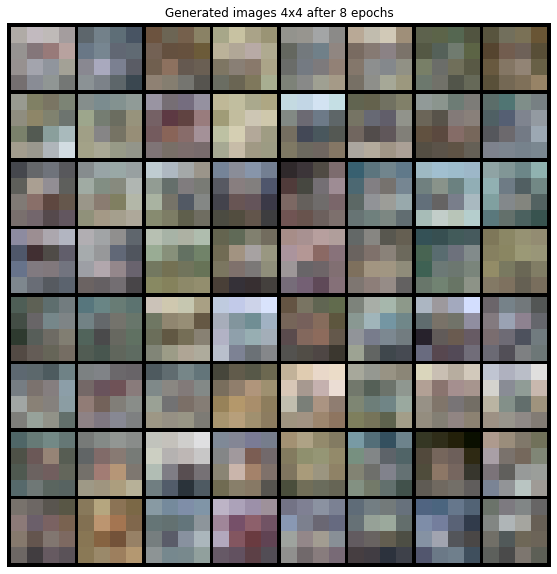

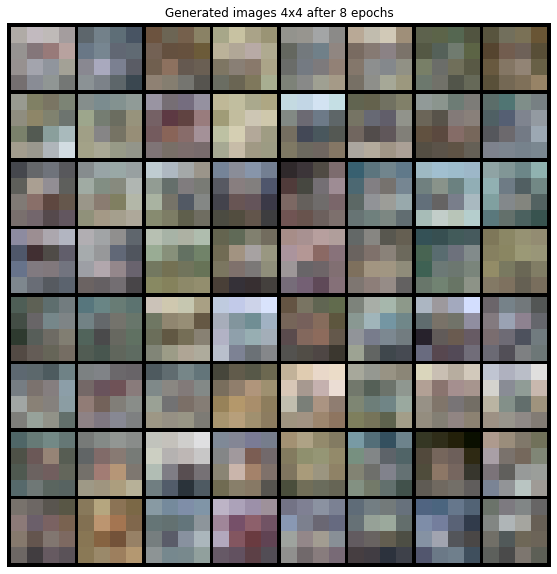



Currently working on Depth:  1
Current resolution: 8 x 8

Epoch: 1
[1/8]	 [0/782]	 Loss_D: 2.226024	Loss_G: 0.302603
[1/8]	 [500/782]	 Loss_D: -0.005743	Loss_G: 0.350865
Time taken for epoch: 48.339 secs

Epoch: 2
[2/8]	 [0/782]	 Loss_D: -0.402888	Loss_G: 0.720084
[2/8]	 [500/782]	 Loss_D: -0.479002	Loss_G: 0.791332
Time taken for epoch: 50.245 secs

Epoch: 3
[3/8]	 [0/782]	 Loss_D: -0.654436	Loss_G: 0.825216
[3/8]	 [500/782]	 Loss_D: -0.748553	Loss_G: 0.903447
Time taken for epoch: 50.075 secs

Epoch: 4
[4/8]	 [0/782]	 Loss_D: -0.263120	Loss_G: 1.028408
[4/8]	 [500/782]	 Loss_D: -0.648410	Loss_G: 0.891715
Time taken for epoch: 50.261 secs

Epoch: 5
[5/8]	 [0/782]	 Loss_D: -0.796993	Loss_G: 1.168485
[5/8]	 [500/782]	 Loss_D: -0.529158	Loss_G: 1.400865
Time taken for epoch: 50.603 secs
Saved checkpoint at epoch:  5


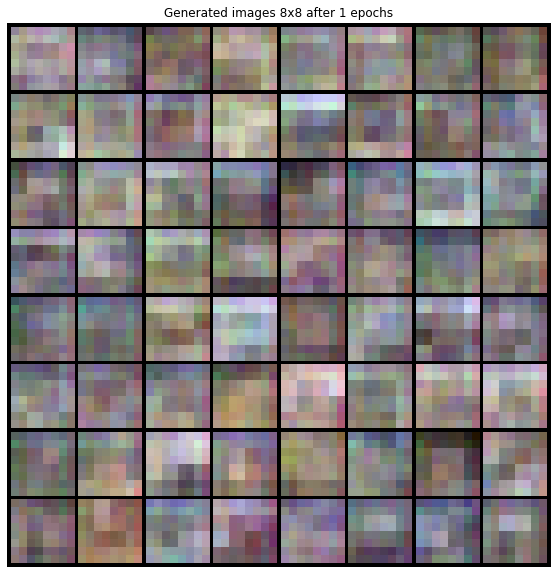

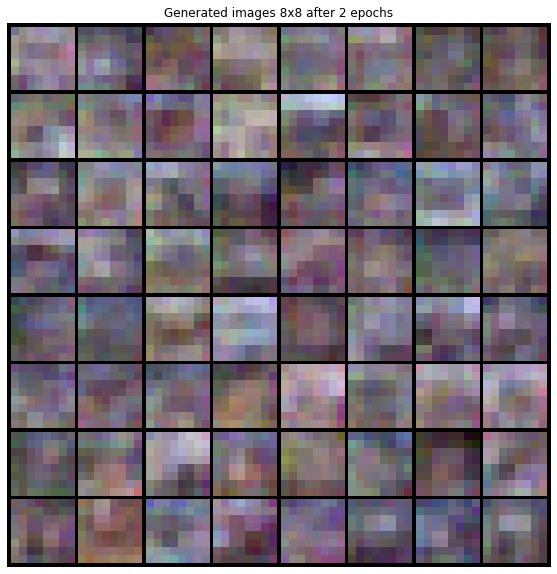

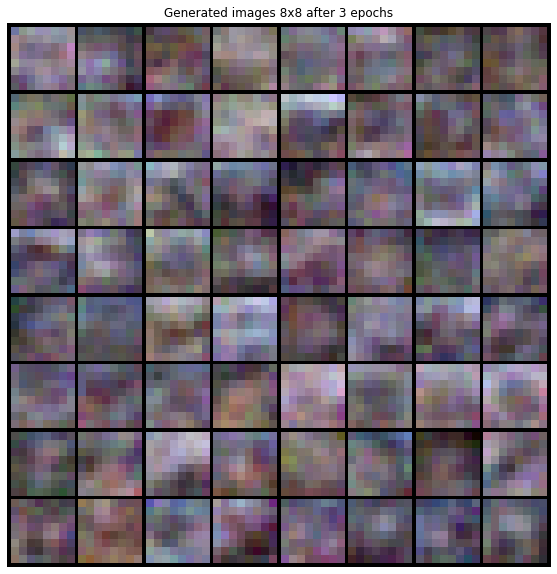

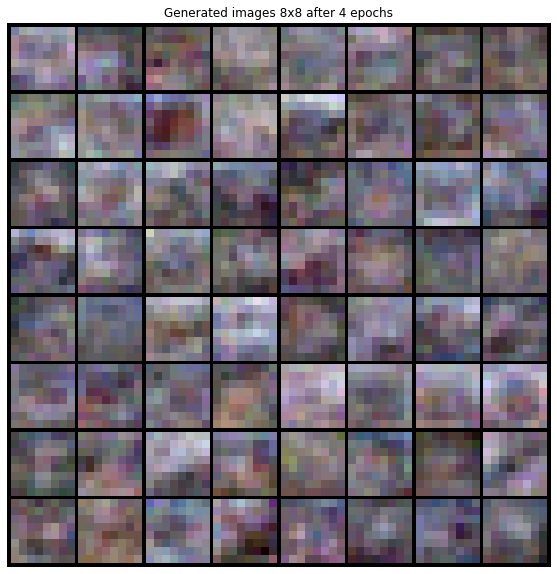

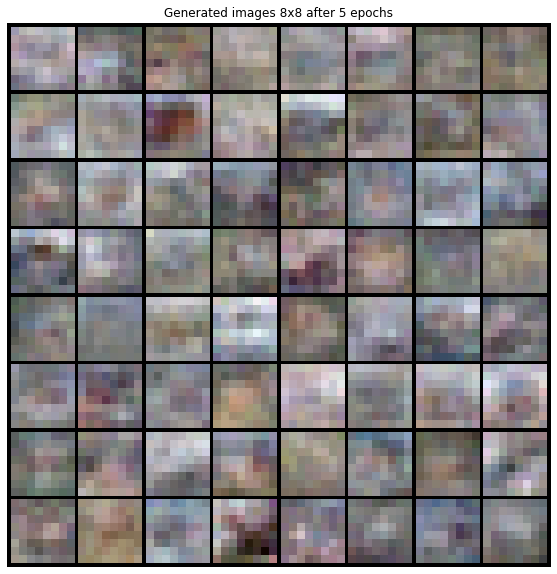

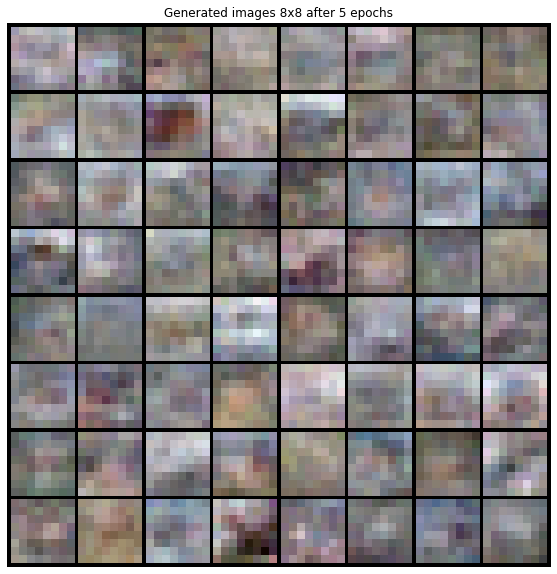


Epoch: 6
[6/8]	 [0/782]	 Loss_D: -0.343738	Loss_G: 1.124513
[6/8]	 [500/782]	 Loss_D: -0.551028	Loss_G: 0.907899
Time taken for epoch: 50.584 secs

Epoch: 7
[7/8]	 [0/782]	 Loss_D: -0.405237	Loss_G: 1.241188
[7/8]	 [500/782]	 Loss_D: -0.492659	Loss_G: -0.091046
Time taken for epoch: 50.555 secs

Epoch: 8
[8/8]	 [0/782]	 Loss_D: -0.208833	Loss_G: 0.692373
[8/8]	 [500/782]	 Loss_D: -0.387691	Loss_G: 0.685505
Time taken for epoch: 50.998 secs
Saved checkpoint at epoch:  8


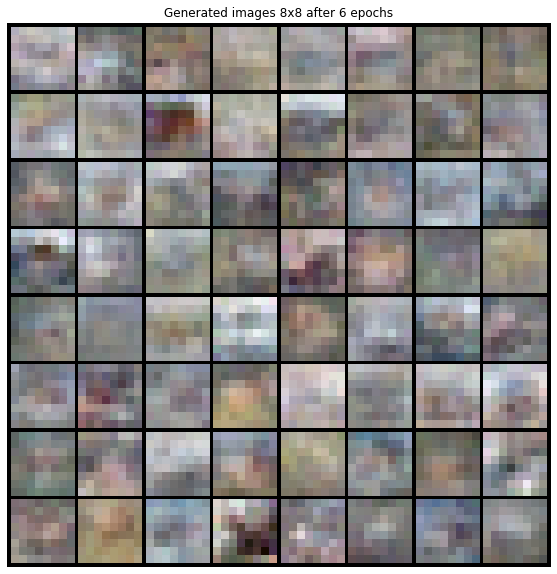

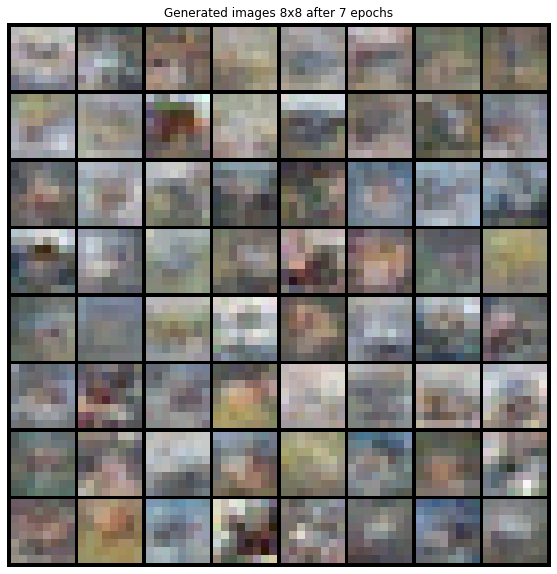

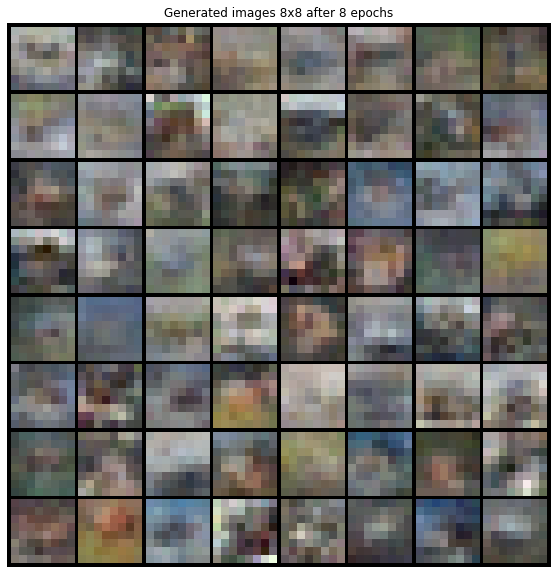

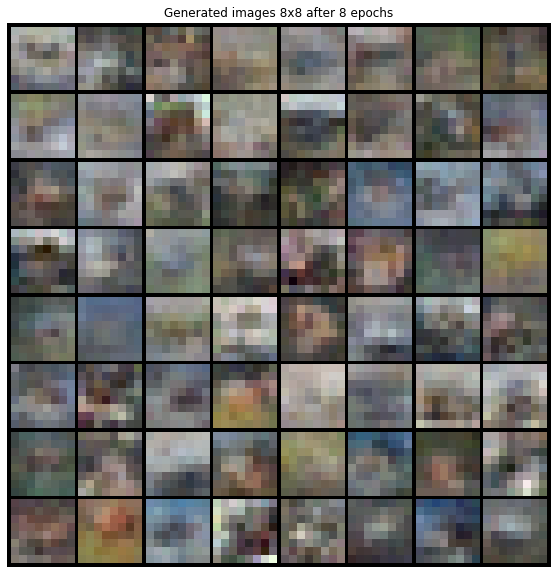



Currently working on Depth:  2
Current resolution: 16 x 16

Epoch: 1
[1/8]	 [0/782]	 Loss_D: 2.364619	Loss_G: 1.021294
[1/8]	 [500/782]	 Loss_D: -1.178649	Loss_G: 1.312363
Time taken for epoch: 65.519 secs

Epoch: 2
[2/8]	 [0/782]	 Loss_D: -0.939841	Loss_G: 1.146945
[2/8]	 [500/782]	 Loss_D: -0.508421	Loss_G: 1.614989
Time taken for epoch: 65.157 secs

Epoch: 3
[3/8]	 [0/782]	 Loss_D: -0.425295	Loss_G: 1.046182
[3/8]	 [500/782]	 Loss_D: -1.048462	Loss_G: 0.601520
Time taken for epoch: 65.156 secs

Epoch: 4
[4/8]	 [0/782]	 Loss_D: -0.664967	Loss_G: 0.483742
[4/8]	 [500/782]	 Loss_D: -0.549719	Loss_G: -0.412417
Time taken for epoch: 65.520 secs

Epoch: 5
[5/8]	 [0/782]	 Loss_D: -0.486134	Loss_G: 0.946690
[5/8]	 [500/782]	 Loss_D: -0.462024	Loss_G: 1.158496
Time taken for epoch: 65.334 secs
Saved checkpoint at epoch:  5


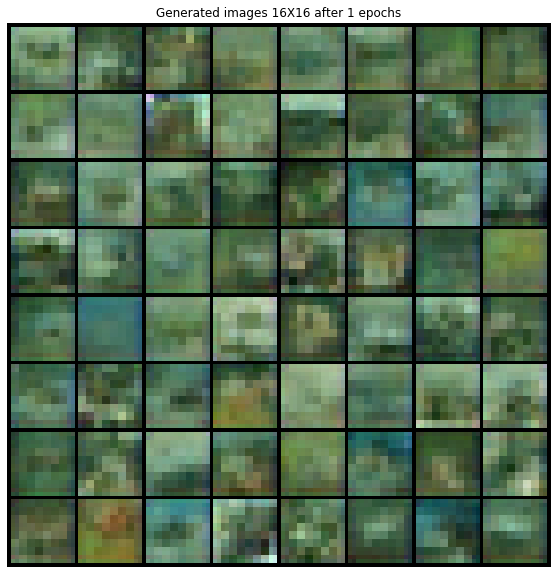

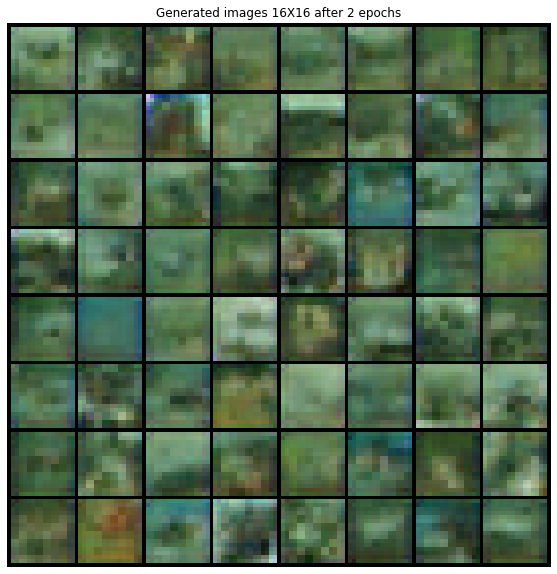

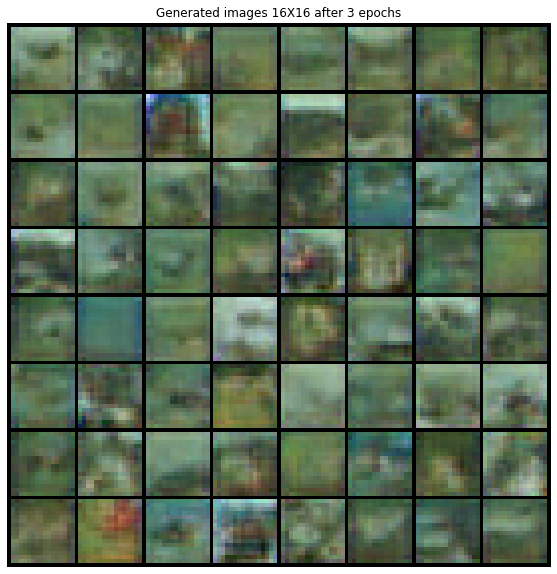

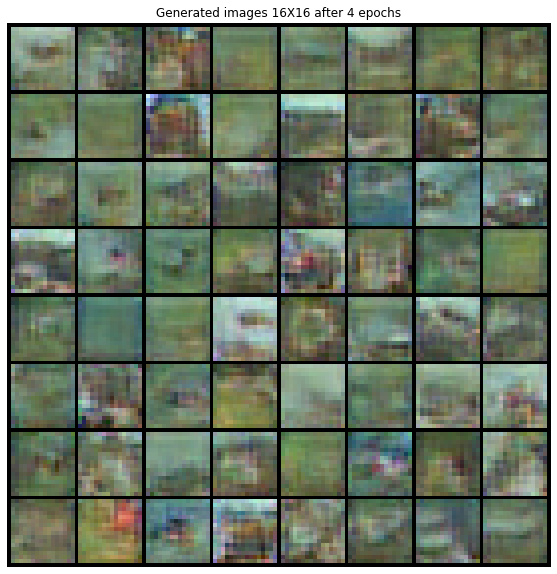

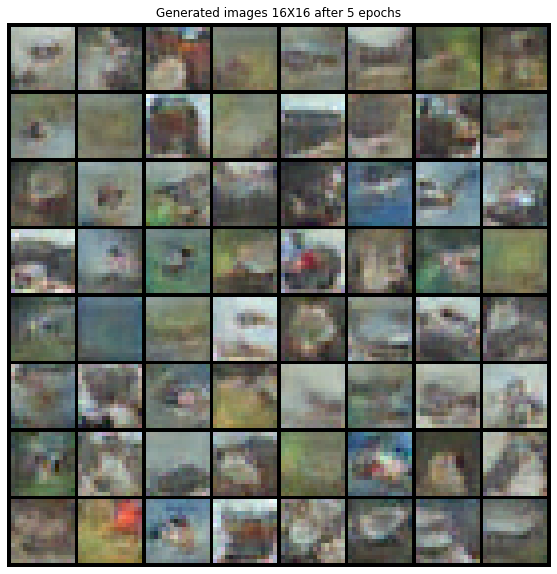

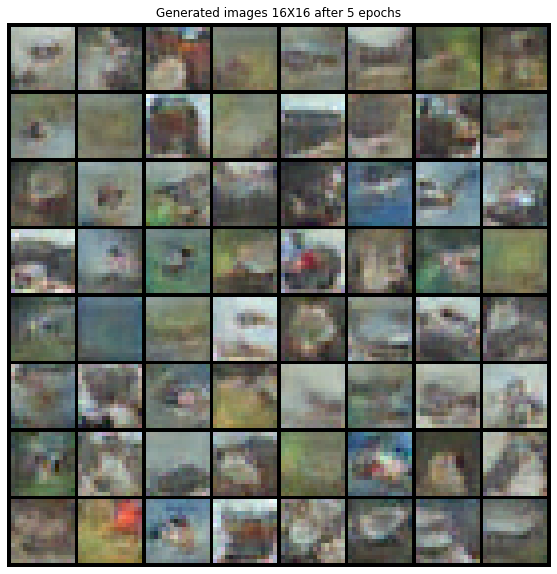


Epoch: 6
[6/8]	 [0/782]	 Loss_D: -0.160429	Loss_G: 1.618088
[6/8]	 [500/782]	 Loss_D: -0.592874	Loss_G: 1.982320
Time taken for epoch: 66.014 secs

Epoch: 7
[7/8]	 [0/782]	 Loss_D: -0.472999	Loss_G: 1.012987
[7/8]	 [500/782]	 Loss_D: -0.528283	Loss_G: 0.990716
Time taken for epoch: 65.503 secs

Epoch: 8
[8/8]	 [0/782]	 Loss_D: 0.472319	Loss_G: -0.301628
[8/8]	 [500/782]	 Loss_D: -0.635133	Loss_G: 1.880864
Time taken for epoch: 65.415 secs
Saved checkpoint at epoch:  8


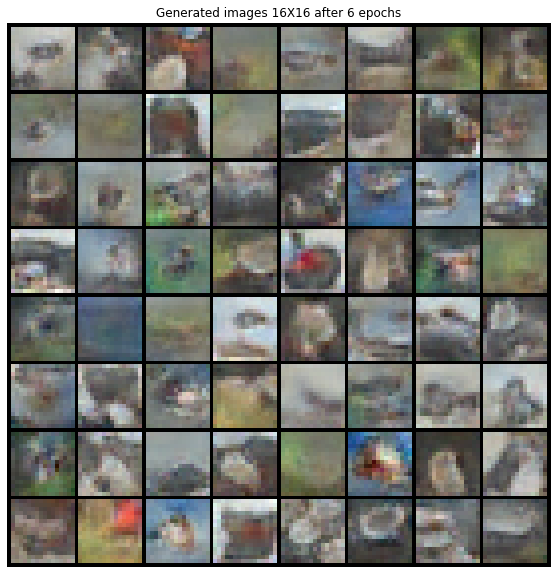

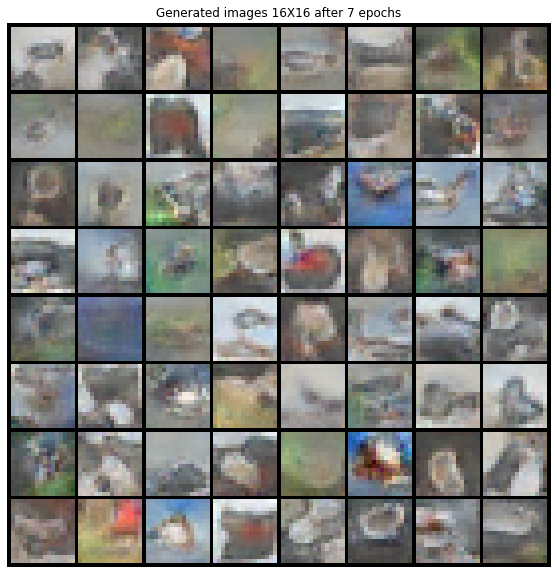

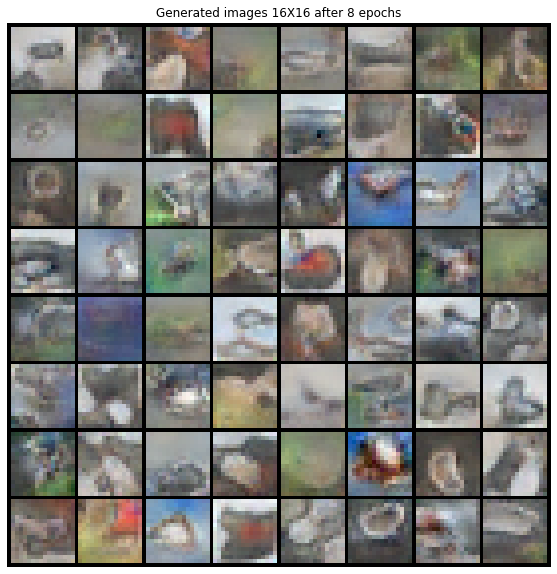

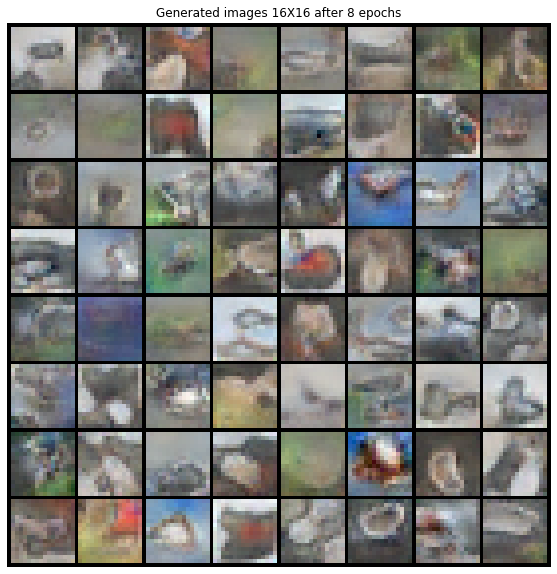



Currently working on Depth:  3
Current resolution: 32 x 32

Epoch: 1
[1/8]	 [0/782]	 Loss_D: 2.051892	Loss_G: 1.861904
[1/8]	 [500/782]	 Loss_D: -0.726974	Loss_G: 1.275721
Time taken for epoch: 203.620 secs

Epoch: 2
[2/8]	 [0/782]	 Loss_D: -0.808855	Loss_G: 0.057314
[2/8]	 [500/782]	 Loss_D: -0.673798	Loss_G: 6.349616
Time taken for epoch: 203.661 secs

Epoch: 3
[3/8]	 [0/782]	 Loss_D: -0.641582	Loss_G: 3.647531
[3/8]	 [500/782]	 Loss_D: -0.772030	Loss_G: 5.594396
Time taken for epoch: 203.580 secs

Epoch: 4
[4/8]	 [0/782]	 Loss_D: -0.739484	Loss_G: 2.111590
[4/8]	 [500/782]	 Loss_D: -0.697879	Loss_G: -0.158476
Time taken for epoch: 203.685 secs

Epoch: 5
[5/8]	 [0/782]	 Loss_D: -0.836704	Loss_G: 2.231807
[5/8]	 [500/782]	 Loss_D: -0.853611	Loss_G: 2.832551
Time taken for epoch: 203.781 secs
Saved checkpoint at epoch:  5


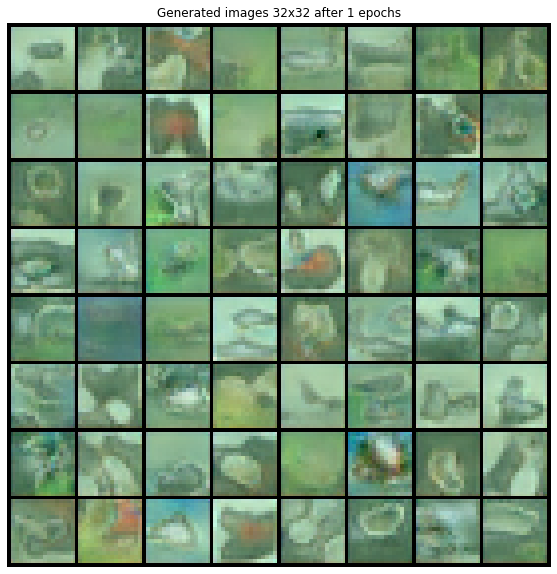

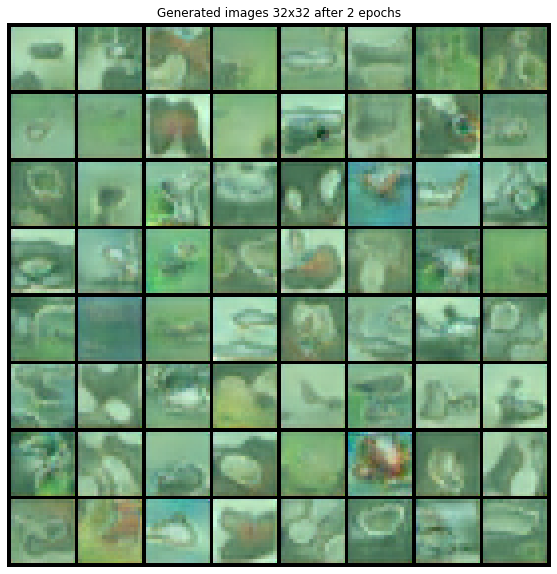

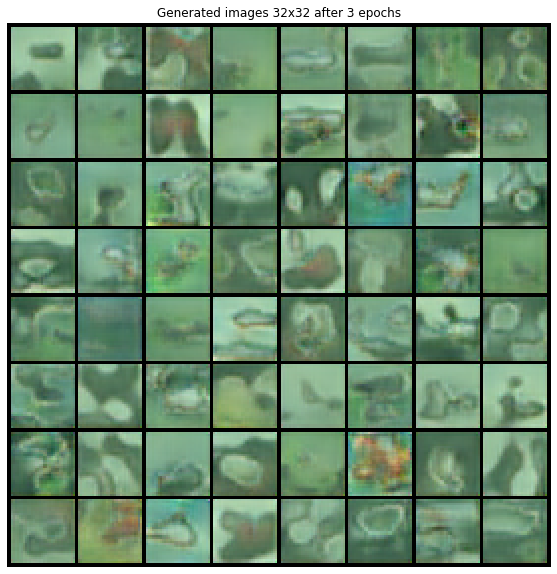

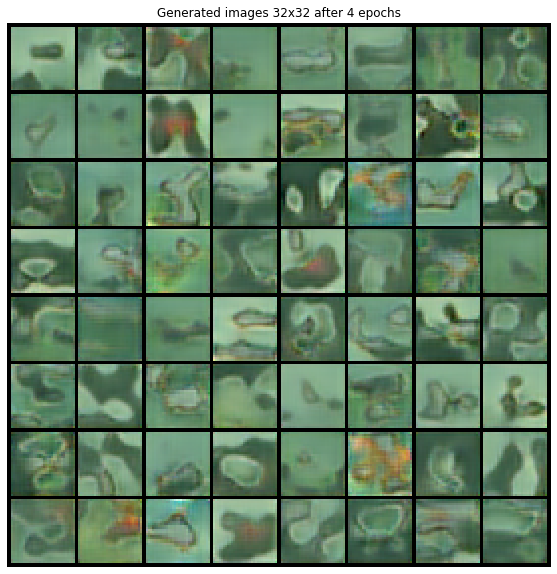

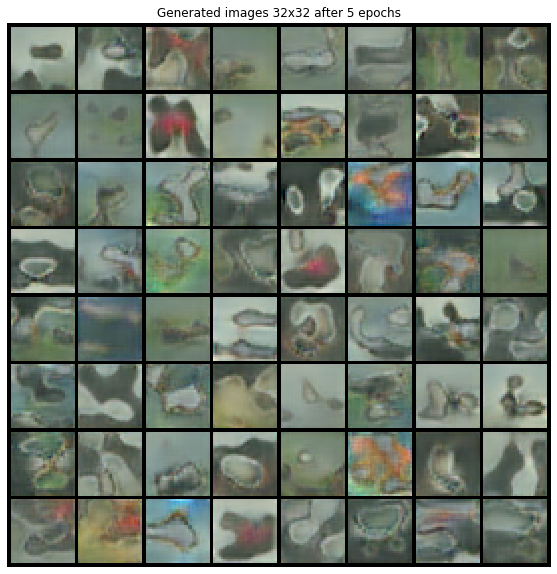

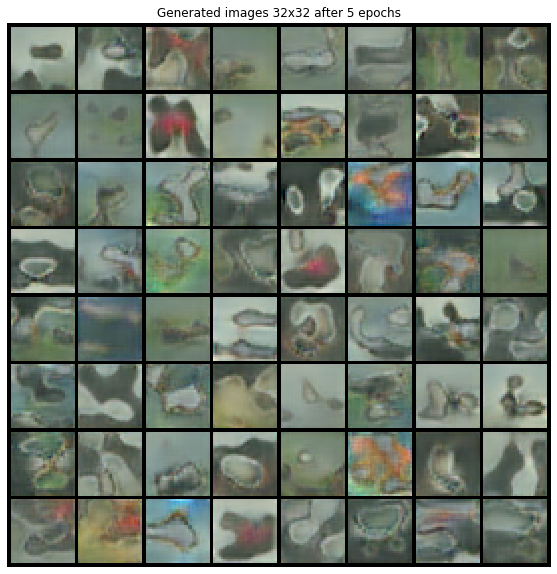


Epoch: 6
[6/8]	 [0/782]	 Loss_D: -1.029060	Loss_G: 1.396298
[6/8]	 [500/782]	 Loss_D: -0.968848	Loss_G: 2.615702
Time taken for epoch: 203.950 secs

Epoch: 7
[7/8]	 [0/782]	 Loss_D: -0.424533	Loss_G: 2.516462
[7/8]	 [500/782]	 Loss_D: -0.928603	Loss_G: 2.674981
Time taken for epoch: 203.845 secs

Epoch: 8
[8/8]	 [0/782]	 Loss_D: -0.386196	Loss_G: 3.761910
[8/8]	 [500/782]	 Loss_D: -1.018149	Loss_G: 0.725890
Time taken for epoch: 203.798 secs
Saved checkpoint at epoch:  8


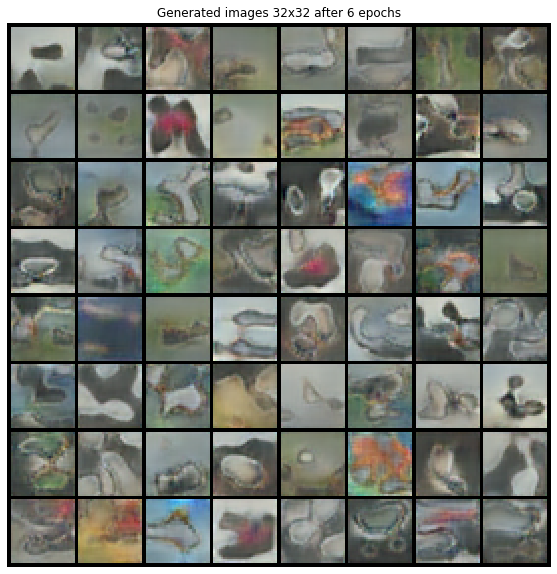

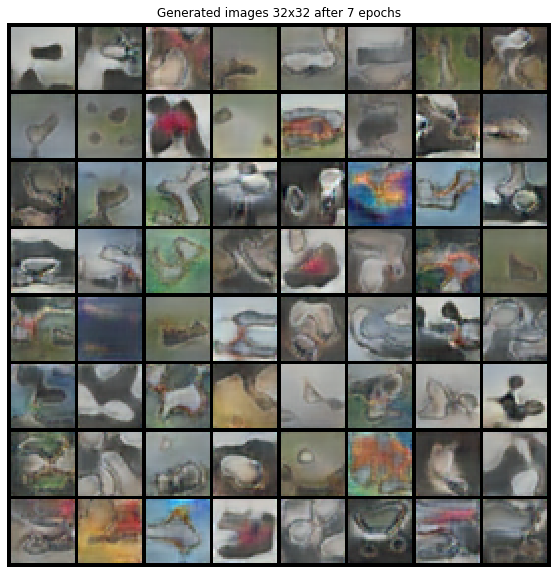

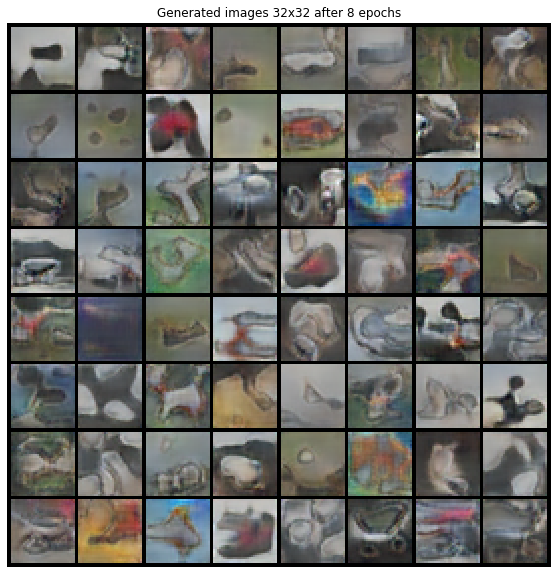

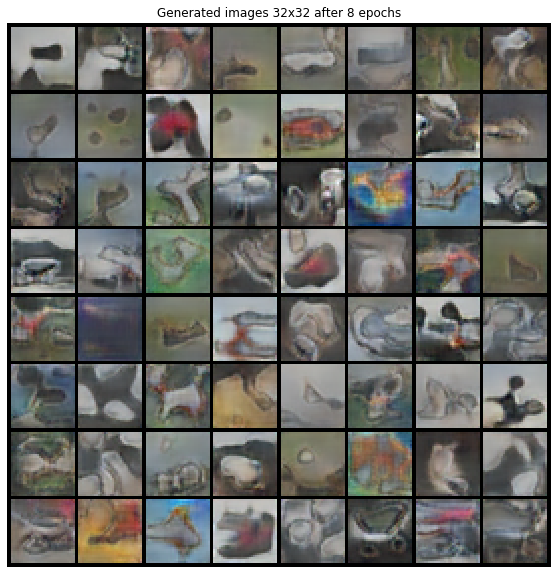

Training completed ...


In [0]:
if __name__ == '__main__':

    # Create the PRO-GAN
    pro_gan = ProGAN(depth=depth, latent_size=latent_size, lr=lr, loss=loss, device=device)

    # Train the PRO-GAN
    pro_gan.train(dataset=dataset, epochs=num_epochs, fade_in_percentage=fade_ins, batch_sizes=batch_sizes)

Possible problems: 

*   Learning rate 
*   Loss function not good for architecture
* Architecture

Pro:
* Faster training
* Good image quality results
* No visible mode collapse

Cons:
* High sensible to hyperparameters
* Some problems with colors in higher resolution
